# Introducción

## Contexto del Problema

El acceso al crédito es un pilar fundamental para el desarrollo económico individual y colectivo. Sin embargo, las instituciones financieras enfrentan el desafío constante de evaluar el **riesgo de incumplimiento** (*default*) de sus clientes. Una evaluación inadecuada puede resultar en pérdidas significativas para la institución o, por otro lado, en la exclusión financiera de personas que podrían cumplir con sus obligaciones.

**Home Credit Group** es una compañía de servicios financieros enfocada en préstamos a poblaciones no bancarizadas o con historial crediticio limitado. El problema que abordamos es la **predicción del riesgo de impago** utilizando técnicas estadísticas multivariadas, con el objetivo de:

1. **Identificar clientes con alta probabilidad de incumplimiento** antes de otorgar el crédito
2. **Comprender los factores que influyen en el impago** para diseñar políticas de mitigación
3. **Equilibrar la inclusión financiera con la gestión del riesgo**

## Marco Conceptual: El Grafo Causal del Impago

Antes de desarrollar nuestros modelos predictivos, construimos un **grafo causal** que representa nuestra comprensión teórica del fenómeno. Este ejercicio de pensamiento causal nos permite identificar las variables relevantes y sus relaciones, fundamentando así nuestro enfoque analítico.


# Introducción

En este cuaderno, realizaremos un análisis exploratorio de datos (EDA) en el conjunto de datos "Home Credit Default Risk" de [Home Credit Group](https://www.kaggle.com/competitions/home-credit-default-risk/data). El objetivo es comprender mejor las características de los datos previo al desarrollo de modelos predictivos.

![dataset-description](https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png)

### Modelo Causal Simplificado

![Grafo Causal Simple](images/Screenshot%202025-12-09%20at%2015.42.37.png)

El impago crediticio puede originarse por dos vías principales:

- **Fraude**: Cuando el cliente nunca tuvo intención de pagar
- **Capacidad de Pago**: Cuando el cliente no puede cumplir con sus obligaciones debido a restricciones económicas

### Modelo Causal Detallado

![Grafo Causal Detallado](images/Screenshot%202025-12-09%20at%2015.43.36.png)

El grafo causal detallado nos muestra las relaciones entre las distintas variables que capturamos en los datos y cómo estas se relacionan con los dos mecanismos principales de impago.


## Hipótesis de Investigación

Con base en el marco causal, formulamos las siguientes hipótesis que guiarán nuestro análisis:

| Hipótesis | Variable Proxy | Relación Esperada |
|-----------|----------------|-------------------|
| Préstamos más altos incrementan la probabilidad de impago | `AMT_CREDIT` | Positiva |
| Menor edad y sin historial crediticio aumenta el riesgo | `EDAD_ANOS`, `ES_PRIMER_CREDITO` | Negativa, Positiva |
| Mal historial crediticio incrementa el riesgo | `EXT_SOURCE_1/2/3`, `SCORE_PROMEDIO` | Negativa |
| Menor ingreso incrementa el riesgo | `AMT_INCOME_TOTAL`, `INGRESO_PER_CAPITA` | Negativa |
| Mayor carga de gastos incrementa el riesgo | `CNT_CHILDREN`, `CNT_FAM_MEMBERS` | Positiva |
| Mayor deuda acumulada incrementa el riesgo | `TOTAL_DEUDA_ACTUAL`, `CREDITOS_ACTIVOS` | Positiva |
| Menos activos incrementan el riesgo | `NUM_ACTIVOS`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY` | Negativa |
| Condiciones crediticias adversas aumentan el riesgo | `TASA_INTERES_PROMEDIO`, `PLAZO_PROMEDIO` | Positiva |

## Preguntas de Investigación

1. ¿Cuáles son las variables con mayor poder predictivo para identificar clientes en riesgo de impago?
2. ¿Qué modelo (Regresión Logística vs Random Forest) ofrece el mejor balance entre interpretabilidad y poder predictivo?
3. ¿Podemos reducir la dimensionalidad del problema sin perder capacidad predictiva?


# Metodología y Datos

## Descripción del Dataset

El conjunto de datos proviene de la competencia [Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk) de Kaggle. La estructura de datos incluye múltiples tablas relacionadas:

- **application_train.csv**: Información principal de las solicitudes (307,511 registros)
- **bureau.csv**: Historial crediticio de otras instituciones (1,716,428 registros)
- **bureau_balance.csv**: Balance mensual de créditos en buró (27,299,925 registros)
- **previous_application.csv**: Solicitudes previas en Home Credit (1,670,214 registros)
- **installments_payments.csv**: Historial de pagos (13,605,401 registros)
- **credit_card_balance.csv**: Balance de tarjetas de crédito (3,840,312 registros)


## Variables

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✓ Librerías cargadas")

✓ Librerías cargadas


In [2]:
!pwd

/Users/jeronimo.deli/Desktop/other/Vs/MM/home_credit_risk_default/reporte-final


In [3]:
print("Cargando datasets...\n")

app_train = pd.read_csv('../data/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('../data/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('../data/home-credit-default-risk/bureau_balance.csv')
prev_app = pd.read_csv('../data/home-credit-default-risk/previous_application.csv')
pos_cash = pd.read_csv('../data/home-credit-default-risk/POS_CASH_balance.csv')
credit_card = pd.read_csv('../data/home-credit-default-risk/credit_card_balance.csv')
installments = pd.read_csv('../data/home-credit-default-risk/installments_payments.csv')

print(f"✓ Application Train: {app_train.shape[0]:,} usuarios")
print(f"✓ Bureau: {bureau.shape[0]:,} registros")
print(f"✓ Bureau Balance: {bureau_balance.shape[0]:,} registros")
print(f"✓ Previous Application: {prev_app.shape[0]:,} registros")
print(f"✓ POS Cash: {pos_cash.shape[0]:,} registros")
print(f"✓ Credit Card: {credit_card.shape[0]:,} registros")
print(f"✓ Installments: {installments.shape[0]:,} registros")
print(f"\n✓ Datos cargados correctamente")

Cargando datasets...

✓ Application Train: 307,511 usuarios
✓ Bureau: 1,716,428 registros
✓ Bureau Balance: 27,299,925 registros
✓ Previous Application: 1,670,214 registros
✓ POS Cash: 10,001,358 registros
✓ Credit Card: 3,840,312 registros
✓ Installments: 13,605,401 registros

✓ Datos cargados correctamente


In [4]:
# ============================================================================
# GENERACIÓN DE FEATURES - VERSIÓN OPTIMIZADA
# ============================================================================
print("="*80)
print("GENERANDO DATASET COMPLETO - VERSIÓN OPTIMIZADA")
print("="*80)
print(f"\nTotal de usuarios: {len(app_train):,}")
print(f"Variables por usuario: 40\n")

# PARTE 1: FEATURES BASE DE APPLICATION
print("Generando features base...")

df = app_train[['SK_ID_CURR', 'TARGET']].copy()

# Features básicas
df['AMT_CREDIT'] = app_train['AMT_CREDIT']
df['AMT_ANNUITY'] = app_train['AMT_ANNUITY']
df['AMT_INCOME_TOTAL'] = app_train['AMT_INCOME_TOTAL']

# Edad
df['DAYS_BIRTH'] = app_train['DAYS_BIRTH']
df['EDAD_ANOS'] = abs(app_train['DAYS_BIRTH']) / 365.25

# Scores externos
df['EXT_SOURCE_1'] = app_train['EXT_SOURCE_1']
df['EXT_SOURCE_2'] = app_train['EXT_SOURCE_2']
df['EXT_SOURCE_3'] = app_train['EXT_SOURCE_3']
df['SCORE_PROMEDIO'] = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)

# Ratios
df['CREDIT_INCOME_RATIO'] = df['AMT_CREDIT'] / df['AMT_INCOME_TOTAL']

# Familia
df['NAME_FAMILY_STATUS'] = app_train['NAME_FAMILY_STATUS']
df['CNT_CHILDREN'] = app_train['CNT_CHILDREN']
df['CNT_FAM_MEMBERS'] = app_train['CNT_FAM_MEMBERS']
df['CODE_GENDER'] = app_train['CODE_GENDER']
df['NAME_EDUCATION_TYPE'] = app_train['NAME_EDUCATION_TYPE']
df['INGRESO_PER_CAPITA'] = np.where(
    df['CNT_FAM_MEMBERS'] > 0,
    df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'],
    df['AMT_INCOME_TOTAL']
)

# Activos
df['FLAG_OWN_CAR'] = app_train['FLAG_OWN_CAR']
df['FLAG_OWN_REALTY'] = app_train['FLAG_OWN_REALTY']
df['NUM_ACTIVOS'] = (app_train['FLAG_OWN_CAR'] == 'Y').astype(int) + \
                    (app_train['FLAG_OWN_REALTY'] == 'Y').astype(int)

# Consultas buró
bureau_cols = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 
               'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
               'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
df['TOTAL_CONSULTAS_BURO'] = app_train[bureau_cols].fillna(0).sum(axis=1)

print("✓ Features base generadas")

# PARTE 2: FEATURES DE BUREAU
print("Procesando features de Bureau...")

bureau_agg = bureau.groupby('SK_ID_CURR').agg({
    'AMT_CREDIT_SUM_LIMIT': 'sum',
    'AMT_CREDIT_SUM': 'sum',
    'AMT_CREDIT_SUM_DEBT': 'sum',
    'CREDIT_DAY_OVERDUE': 'max',
    'SK_ID_BUREAU': 'count'
}).reset_index()

bureau_agg.columns = ['SK_ID_CURR', 'TOTAL_CREDITO_DISPONIBLE', 
                      'TOTAL_CREDITO_OTORGADO', 'TOTAL_DEUDA_ACTUAL',
                      'MAX_DIAS_MORA', 'CANTIDAD_CREDITOS_BURO']

# Créditos activos y cerrados
bureau_active = bureau[bureau['CREDIT_ACTIVE'] == 'Active'].groupby('SK_ID_CURR').size().reset_index(name='CREDITOS_ACTIVOS')
bureau_closed = bureau[bureau['CREDIT_ACTIVE'] == 'Closed'].groupby('SK_ID_CURR').size().reset_index(name='CREDITOS_CERRADOS')

bureau_agg = bureau_agg.merge(bureau_active, on='SK_ID_CURR', how='left')
bureau_agg = bureau_agg.merge(bureau_closed, on='SK_ID_CURR', how='left')

bureau_agg['CREDITOS_ACTIVOS'] = bureau_agg['CREDITOS_ACTIVOS'].fillna(0)
bureau_agg['CREDITOS_CERRADOS'] = bureau_agg['CREDITOS_CERRADOS'].fillna(0)
bureau_agg['TIENE_IMPAGOS'] = (bureau_agg['MAX_DIAS_MORA'] > 0).astype(int)

# Merge con df principal
df = df.merge(bureau_agg, on='SK_ID_CURR', how='left')

# Llenar NaN
bureau_fill_cols = ['TOTAL_CREDITO_DISPONIBLE', 'TOTAL_CREDITO_OTORGADO', 
                    'TOTAL_DEUDA_ACTUAL', 'CREDITOS_ACTIVOS', 'CREDITOS_CERRADOS',
                    'MAX_DIAS_MORA', 'TIENE_IMPAGOS', 'CANTIDAD_CREDITOS_BURO']
df[bureau_fill_cols] = df[bureau_fill_cols].fillna(0)

df['ES_PRIMER_CREDITO'] = (df['CANTIDAD_CREDITOS_BURO'] == 0).astype(int)

print("✓ Features de Bureau generadas")

# PARTE 3: FEATURES DE BUREAU BALANCE
print("Procesando Bureau Balance...")

bureau_balance_merged = bureau_balance.merge(
    bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], 
    on='SK_ID_BUREAU', 
    how='left'
)

mora_status = ['1', '2', '3', '4', '5']
bureau_balance_merged['EN_MORA'] = bureau_balance_merged['STATUS'].isin(mora_status).astype(int)

balance_agg = bureau_balance_merged.groupby('SK_ID_CURR').agg({
    'EN_MORA': 'sum',
    'STATUS': 'count'
}).reset_index()

balance_agg.columns = ['SK_ID_CURR', 'MESES_CON_MORA', 'TOTAL_MESES']
balance_agg['PCT_MESES_MORA'] = (balance_agg['MESES_CON_MORA'] / balance_agg['TOTAL_MESES']) * 100

# Créditos con impago
creditos_impago = bureau_balance_merged.groupby(['SK_ID_CURR', 'SK_ID_BUREAU'])['EN_MORA'].max().reset_index()
creditos_impago_count = creditos_impago.groupby('SK_ID_CURR')['EN_MORA'].sum().reset_index()
creditos_impago_count.columns = ['SK_ID_CURR', 'CREDITOS_CON_IMPAGO']

balance_agg = balance_agg.merge(creditos_impago_count, on='SK_ID_CURR', how='left')

df = df.merge(balance_agg[['SK_ID_CURR', 'MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO']], 
              on='SK_ID_CURR', how='left')

df[['MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO']] = \
    df[['MESES_CON_MORA', 'PCT_MESES_MORA', 'CREDITOS_CON_IMPAGO']].fillna(0)

print("✓ Features de Bureau Balance generadas")

# PARTE 4: FEATURES DE PREVIOUS APPLICATION
print("Procesando Previous Applications...")

prev_agg = prev_app.groupby('SK_ID_CURR').agg({
    'SK_ID_PREV': 'count',
    'RATE_INTEREST_PRIMARY': 'mean',
    'CNT_PAYMENT': 'mean',
    'AMT_CREDIT': ['mean', 'sum']
}).reset_index()

prev_agg.columns = ['SK_ID_CURR', 'NUM_PRESTAMOS_PREVIOS', 'TASA_INTERES_PROMEDIO',
                    'PLAZO_PROMEDIO', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO']

df = df.merge(prev_agg, on='SK_ID_CURR', how='left')

df[['NUM_PRESTAMOS_PREVIOS', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO']] = \
    df[['NUM_PRESTAMOS_PREVIOS', 'MONTO_PROMEDIO_PREVIO', 'TOTAL_CREDITO_HISTORICO']].fillna(0)

print("✓ Features de Previous Applications generadas")

# PARTE 5: FEATURES DE INSTALLMENTS
print("Procesando Installments...")

valid_installments = installments[installments['AMT_INSTALMENT'] > 0].copy()
valid_installments['PAYMENT_RATIO'] = valid_installments['AMT_PAYMENT'] / valid_installments['AMT_INSTALMENT']

install_agg = valid_installments.groupby('SK_ID_CURR')['PAYMENT_RATIO'].mean().reset_index()
install_agg.columns = ['SK_ID_CURR', 'RATIO_PAGO_CUOTA']

df = df.merge(install_agg, on='SK_ID_CURR', how='left')

print("✓ Features de Installments generadas")

# PARTE 6: FEATURES DE CREDIT CARD
print("Procesando Credit Card Balance...")

valid_cc = credit_card[credit_card['AMT_INST_MIN_REGULARITY'] > 0].copy()
valid_cc['PAYMENT_MIN_RATIO'] = valid_cc['AMT_PAYMENT_CURRENT'] / valid_cc['AMT_INST_MIN_REGULARITY']

cc_agg = valid_cc.groupby('SK_ID_CURR')['PAYMENT_MIN_RATIO'].mean().reset_index()
cc_agg.columns = ['SK_ID_CURR', 'RATIO_PAGO_MINIMO_TC']

df = df.merge(cc_agg, on='SK_ID_CURR', how='left')

print("✓ Features de Credit Card generadas")

# RESULTADO FINAL
print("\n" + "="*80)
print("✅ DATASET COMPLETO GENERADO")
print("="*80)
print(f"Usuarios procesados: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Shape: {df.shape}")
print(f"Memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("="*80)

GENERANDO DATASET COMPLETO - VERSIÓN OPTIMIZADA

Total de usuarios: 307,511
Variables por usuario: 40

Generando features base...
✓ Features base generadas
Procesando features de Bureau...
✓ Features de Bureau generadas
Procesando Bureau Balance...
✓ Features de Bureau Balance generadas
Procesando Previous Applications...
✓ Features de Previous Applications generadas
Procesando Installments...
✓ Features de Installments generadas
Procesando Credit Card Balance...
✓ Features de Credit Card generadas

✅ DATASET COMPLETO GENERADO
Usuarios procesados: 307,511
Variables: 41
Shape: (307511, 41)
Memoria: 167.42 MB


In [5]:
df

,SK_ID_CURR,TARGET,AMT_CREDIT,AMT_ANNUITY,AMT_INCOME_TOTAL,DAYS_BIRTH,EDAD_ANOS,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,SCORE_PROMEDIO,CREDIT_INCOME_RATIO,NAME_FAMILY_STATUS,CNT_CHILDREN,CNT_FAM_MEMBERS,CODE_GENDER,NAME_EDUCATION_TYPE,INGRESO_PER_CAPITA,FLAG_OWN_CAR,FLAG_OWN_REALTY,NUM_ACTIVOS,TOTAL_CONSULTAS_BURO,TOTAL_CREDITO_DISPONIBLE,TOTAL_CREDITO_OTORGADO,TOTAL_DEUDA_ACTUAL,MAX_DIAS_MORA,CANTIDAD_CREDITOS_BURO,CREDITOS_ACTIVOS,CREDITOS_CERRADOS,TIENE_IMPAGOS,ES_PRIMER_CREDITO,MESES_CON_MORA,PCT_MESES_MORA,CREDITOS_CON_IMPAGO,NUM_PRESTAMOS_PREVIOS,TASA_INTERES_PROMEDIO,PLAZO_PROMEDIO,MONTO_PROMEDIO_PREVIO,TOTAL_CREDITO_HISTORICO,RATIO_PAGO_CUOTA,RATIO_PAGO_MINIMO_TC
0,100002,1,406597.500,24700.500,202500.000,-9461,25.903,0.083,0.263,0.139,0.162,2.008,Single / not married,0,1.000,M,Secondary / secondary special,202500.000,N,Y,1,1.000,31988.565,865055.565,245781.000,0.000,8.000,2.000,6.000,0.000,0,27.000,24.545,6.000,1.000,NaN,24.000,179055.000,179055.000,1.000,NaN
1,100003,0,1293502.500,35698.500,270000.000,-16765,45.900,0.311,0.622,NaN,0.467,4.791,Married,0,2.000,F,Higher education,135000.000,N,N,0,0.000,810000.000,1017400.500,0.000,0.000,4.000,1.000,3.000,0.000,0,0.000,0.000,0.000,3.000,NaN,10.000,484191.000,1452573.000,1.000,NaN
2,100004,0,135000.000,6750.000,67500.000,-19046,52.145,NaN,0.556,0.730,0.643,2.000,Single / not married,0,1.000,M,Secondary / secondary special,67500.000,Y,Y,2,0.000,0.000,189037.800,0.000,0.000,2.000,0.000,2.000,0.000,0,0.000,0.000,0.000,1.000,NaN,4.000,20106.000,20106.000,1.000,NaN
3,100006,0,312682.500,29686.500,135000.000,-19005,52.033,NaN,0.650,NaN,0.650,2.316,Civil marriage,0,2.000,F,Secondary / secondary special,67500.000,N,Y,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0.000,0.000,0.000,9.000,NaN,23.000,291695.500,2625259.500,1.000,NaN
4,100007,0,513000.000,21865.500,121500.000,-19932,54.571,NaN,0.323,NaN,0.323,4.222,Single / not married,0,1.000,M,Secondary / secondary special,121500.000,N,Y,1,0.000,0.000,146250.000,0.000,0.000,1.000,0.000,1.000,0.000,0,0.000,0.000,0.000,6.000,NaN,20.667,166638.750,999832.500,0.955,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,254700.000,27558.000,157500.000,-9327,25.536,0.146,0.682,NaN,0.414,1.617,Separated,0,1.000,M,Secondary / secondary special,157500.000,N,N,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0.000,0.000,0.000,1.000,NaN,8.000,40455.000,40455.000,1.000,NaN
307507,456252,0,269550.000,12001.500,72000.000,-20775,56.879,NaN,0.116,NaN,0.116,3.744,Widow,0,1.000,F,Secondary / secondary special,72000.000,N,Y,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0.000,0.000,0.000,1.000,NaN,6.000,56821.500,56821.500,1.000,NaN
307508,456253,0,677664.000,29979.000,153000.000,-14966,40.975,0.744,0.536,0.219,0.500,4.429,Separated,0,1.000,F,Higher education,153000.000,N,Y,1,3.000,0.000,3960000.000,1795833.000,0.000,4.000,2.000,2.000,0.000,0,0.000,0.000,0.000,2.000,NaN,5.000,20625.750,41251.500,0.929,NaN
307509,456254,1,370107.000,20205.000,171000.000,-11961,32.747,NaN,0.514,0.661,0.588,2.164,Married,0,2.000,F,Secondary / secondary special,85500.000,N,Y,1,0.000,0.000,45000.000,0.000,0.000,1.000,0.000,1.000,0.000,0,0.000,0.000,0.000,2.000,NaN,15.000,134439.750,268879.500,1.000,NaN



[CORRELACIONES] Calculando matriz de correlación...

Top correlaciones entre variables:

CANTIDAD_CREDITOS_BURO   CREDITOS_CERRADOS         0.933
CREDITOS_CERRADOS        CANTIDAD_CREDITOS_BURO    0.933
CNT_CHILDREN             CNT_FAM_MEMBERS           0.879
CNT_FAM_MEMBERS          CNT_CHILDREN              0.879
AMT_INCOME_TOTAL         INGRESO_PER_CAPITA        0.862
INGRESO_PER_CAPITA       AMT_INCOME_TOTAL          0.862
AMT_CREDIT               AMT_ANNUITY               0.770
AMT_ANNUITY              AMT_CREDIT                0.770
EXT_SOURCE_2             SCORE_PROMEDIO            0.749
SCORE_PROMEDIO           EXT_SOURCE_2              0.749
CANTIDAD_CREDITOS_BURO   CREDITOS_ACTIVOS          0.744
CREDITOS_ACTIVOS         CANTIDAD_CREDITOS_BURO    0.744
SCORE_PROMEDIO           EXT_SOURCE_1              0.742
EXT_SOURCE_1             SCORE_PROMEDIO            0.742
SCORE_PROMEDIO           EXT_SOURCE_3              0.704
EXT_SOURCE_3             SCORE_PROMEDIO            0.70

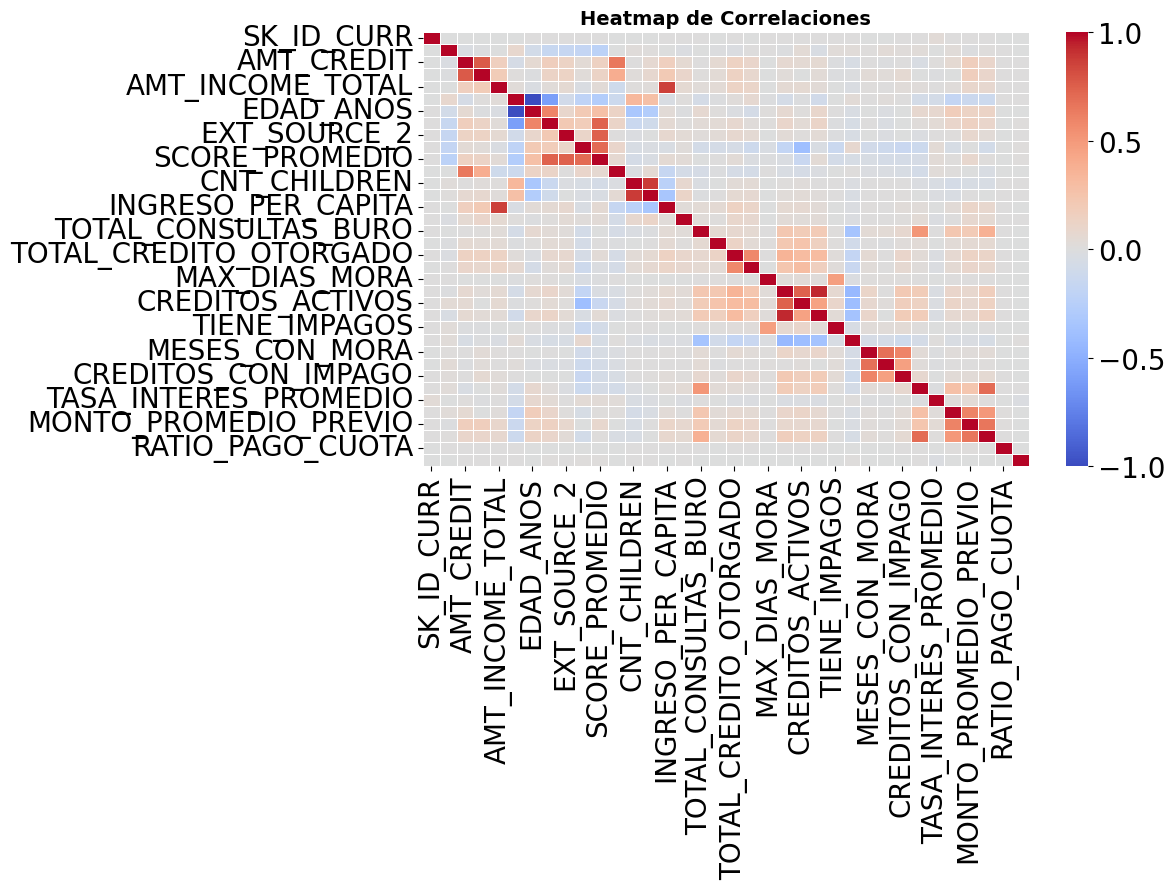

In [6]:
# =============================================================================
# ANALISIS DE CORRELACIONES
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n[CORRELACIONES] Calculando matriz de correlación...")

# 1. Matriz de correlaciones
corr_matrix = df.corr(numeric_only=True)

# 2. Imprimir correlaciones ordenadas por magnitud
corr_pairs = (
    corr_matrix
    .abs()
    .unstack()
    .sort_values(ascending=False)
)

# Filtrar duplicados (solo mitad superior)
corr_pairs = corr_pairs[corr_pairs < 1]

print("\nTop correlaciones entre variables:\n")
print(corr_pairs.head(20))

# 3. Heatmap de correlación
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Heatmap de Correlaciones", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")

print("\nHeatmap guardado como: correlation_heatmap.png")


### variables train 

In [7]:
# Drop de variables redundantes/derivadas
df = df.drop(columns=[
    # Edad
    'DAYS_BIRTH',
    
    # Montos base
    'AMT_CREDIT',
    'AMT_INCOME_TOTAL',
    'AMT_ANNUITY',
    
    # Scores individuales
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    
    # Familia
    'CNT_FAM_MEMBERS',
    
    # Activos
    'FLAG_OWN_CAR',
    'FLAG_OWN_REALTY',
    
    # Consultas buró total
    #'TOTAL_CONSULTAS_BURO',
    
    # Componentes de ratios (solo MESES_CON_MORA está en df)
    'MESES_CON_MORA',
    
    # Variables binarias derivadas
    'TIENE_IMPAGOS',
    'ES_PRIMER_CREDITO',
    
    # Créditos buró
    'CANTIDAD_CREDITOS_BURO'
])

print(f"Variables restantes: {df.shape[1]}")
print(f"Observaciones: {df.shape[0]:,}")

Variables restantes: 27
Observaciones: 307,511



[CORRELACIONES] Calculando matriz de correlación...

Top correlaciones entre variables:

NUM_PRESTAMOS_PREVIOS    TOTAL_CREDITO_HISTORICO   0.701
TOTAL_CREDITO_HISTORICO  NUM_PRESTAMOS_PREVIOS     0.701
                         MONTO_PROMEDIO_PREVIO     0.659
MONTO_PROMEDIO_PREVIO    TOTAL_CREDITO_HISTORICO   0.659
PLAZO_PROMEDIO           MONTO_PROMEDIO_PREVIO     0.602
MONTO_PROMEDIO_PREVIO    PLAZO_PROMEDIO            0.602
TOTAL_CREDITO_OTORGADO   TOTAL_DEUDA_ACTUAL        0.582
TOTAL_DEUDA_ACTUAL       TOTAL_CREDITO_OTORGADO    0.582
NUM_PRESTAMOS_PREVIOS    TOTAL_CONSULTAS_BURO      0.510
TOTAL_CONSULTAS_BURO     NUM_PRESTAMOS_PREVIOS     0.510
PLAZO_PROMEDIO           TOTAL_CREDITO_HISTORICO   0.507
TOTAL_CREDITO_HISTORICO  PLAZO_PROMEDIO            0.507
CREDITOS_CON_IMPAGO      PCT_MESES_MORA            0.462
PCT_MESES_MORA           CREDITOS_CON_IMPAGO       0.462
CREDITOS_ACTIVOS         CREDITOS_CERRADOS         0.456
CREDITOS_CERRADOS        CREDITOS_ACTIVOS          0.45

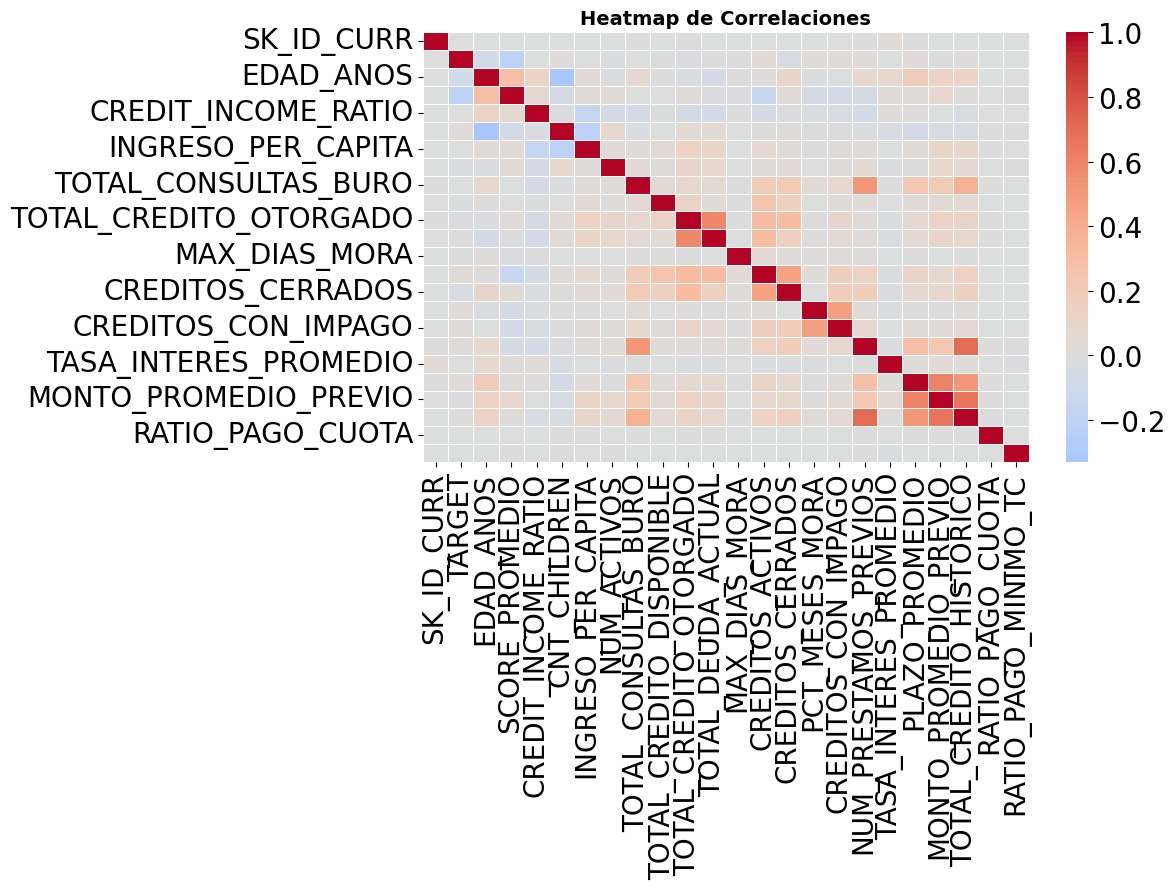

In [8]:
# =============================================================================
# ANALISIS DE CORRELACIONES
# =============================================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("\n[CORRELACIONES] Calculando matriz de correlación...")

# 1. Matriz de correlaciones
corr_matrix = df.corr(numeric_only=True)

# 2. Imprimir correlaciones ordenadas por magnitud
corr_pairs = (
    corr_matrix
    .abs()
    .unstack()
    .sort_values(ascending=False)
)

# Filtrar duplicados (solo mitad superior)
corr_pairs = corr_pairs[corr_pairs < 1]

print("\nTop correlaciones entre variables:\n")
print(corr_pairs.head(20))

# 3. Heatmap de correlación
plt.figure(figsize=(12, 9))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Heatmap de Correlaciones", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches="tight")

print("\nHeatmap guardado como: correlation_heatmap.png")


In [9]:
print("Primeras 10 filas del dataset:\n")
df

Primeras 10 filas del dataset:



,SK_ID_CURR,TARGET,EDAD_ANOS,SCORE_PROMEDIO,CREDIT_INCOME_RATIO,NAME_FAMILY_STATUS,CNT_CHILDREN,CODE_GENDER,NAME_EDUCATION_TYPE,INGRESO_PER_CAPITA,NUM_ACTIVOS,TOTAL_CONSULTAS_BURO,TOTAL_CREDITO_DISPONIBLE,TOTAL_CREDITO_OTORGADO,TOTAL_DEUDA_ACTUAL,MAX_DIAS_MORA,CREDITOS_ACTIVOS,CREDITOS_CERRADOS,PCT_MESES_MORA,CREDITOS_CON_IMPAGO,NUM_PRESTAMOS_PREVIOS,TASA_INTERES_PROMEDIO,PLAZO_PROMEDIO,MONTO_PROMEDIO_PREVIO,TOTAL_CREDITO_HISTORICO,RATIO_PAGO_CUOTA,RATIO_PAGO_MINIMO_TC
0,100002,1,25.903,0.162,2.008,Single / not married,0,M,Secondary / secondary special,202500.000,1,1.000,31988.565,865055.565,245781.000,0.000,2.000,6.000,24.545,6.000,1.000,NaN,24.000,179055.000,179055.000,1.000,NaN
1,100003,0,45.900,0.467,4.791,Married,0,F,Higher education,135000.000,0,0.000,810000.000,1017400.500,0.000,0.000,1.000,3.000,0.000,0.000,3.000,NaN,10.000,484191.000,1452573.000,1.000,NaN
2,100004,0,52.145,0.643,2.000,Single / not married,0,M,Secondary / secondary special,67500.000,2,0.000,0.000,189037.800,0.000,0.000,0.000,2.000,0.000,0.000,1.000,NaN,4.000,20106.000,20106.000,1.000,NaN
3,100006,0,52.033,0.650,2.316,Civil marriage,0,F,Secondary / secondary special,67500.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9.000,NaN,23.000,291695.500,2625259.500,1.000,NaN
4,100007,0,54.571,0.323,4.222,Single / not married,0,M,Secondary / secondary special,121500.000,1,0.000,0.000,146250.000,0.000,0.000,0.000,1.000,0.000,0.000,6.000,NaN,20.667,166638.750,999832.500,0.955,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,25.536,0.414,1.617,Separated,0,M,Secondary / secondary special,157500.000,0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,NaN,8.000,40455.000,40455.000,1.000,NaN
307507,456252,0,56.879,0.116,3.744,Widow,0,F,Secondary / secondary special,72000.000,1,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,NaN,6.000,56821.500,56821.500,1.000,NaN
307508,456253,0,40.975,0.500,4.429,Separated,0,F,Higher education,153000.000,1,3.000,0.000,3960000.000,1795833.000,0.000,2.000,2.000,0.000,0.000,2.000,NaN,5.000,20625.750,41251.500,0.929,NaN
307509,456254,1,32.747,0.588,2.164,Married,0,F,Secondary / secondary special,85500.000,1,0.000,0.000,45000.000,0.000,0.000,0.000,1.000,0.000,0.000,2.000,NaN,15.000,134439.750,268879.500,1.000,NaN


MODELO DE REGRESION LOGISTICA - HOME CREDIT DEFAULT RISK

[1/15] Verificando datos existentes...
Dataset en memoria: (307511, 27)
Usuarios: 307,511
Variables: 27
Tasa de default: 8.07%

[2/15] Preparando datos...
Variables predictoras: 25
Variable objetivo: TARGET
Variables numericas: 22
Variables categoricas: 3

[3/15] Analizando valores faltantes...
Variables con valores faltantes: 5
TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
SCORE_PROMEDIO           0.056
dtype: float64
Imputando valores faltantes...
Valores faltantes imputados

[4/15] Codificando variables categoricas...
3 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']

[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)

[6/15] Normalizando vari

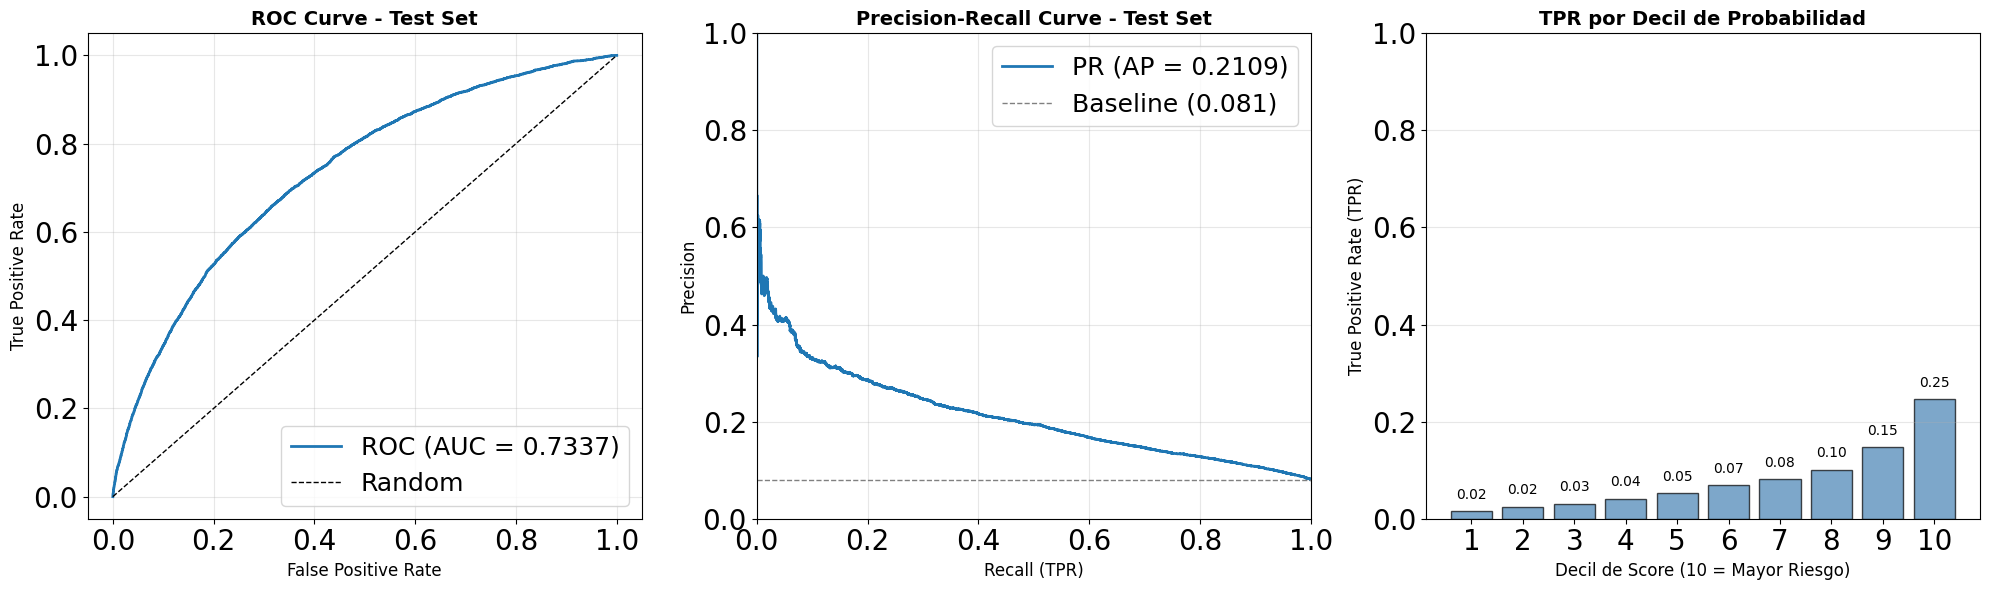

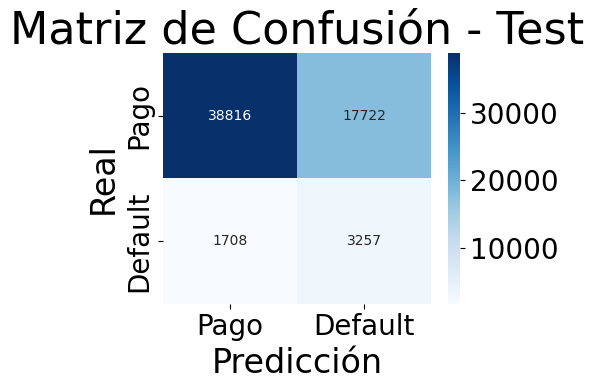

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import pickle
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

print("="*80)
print("MODELO DE REGRESION LOGISTICA - HOME CREDIT DEFAULT RISK")
print("="*80)

# =============================================================================
# 1. VERIFICACIÓN DE DATOS
# =============================================================================
print("\n[1/15] Verificando datos existentes...")
print(f"Dataset en memoria: {df.shape}")
print(f"Usuarios: {len(df):,}")
print(f"Variables: {len(df.columns)}")
print(f"Tasa de default: {df['TARGET'].mean()*100:.2f}%")

# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/15] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")

# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("Imputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")

# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")

# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")

# =============================================================================
# 6. NORMALIZACIÓN
# =============================================================================
print("\n[6/15] Normalizando variables (StandardScaler)...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Datos normalizados (media=0, std=1)")
print(f"Media de features en train: {X_train_scaled.mean():.6f}")
print(f"Std de features en train: {X_train_scaled.std():.6f}")

# =============================================================================
# 7. ENTRENAMIENTO DEL MODELO
# =============================================================================
print("\n[7/15] Entrenando Regresion Logistica...")

model = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

model.fit(X_train_scaled, y_train)

print("Modelo entrenado exitosamente")
print(f"Iteraciones: {model.n_iter_[0]}")
print(f"Clases: {model.classes_}")

# =============================================================================
# 8. VALIDACIÓN CRUZADA
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores = cross_val_score(
    model, X_train_scaled, y_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores}")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# =============================================================================
# 9. PREDICCIONES
# =============================================================================
print("\n[9/15] Generando predicciones...")

y_train_pred = model.predict(X_train_scaled)
y_train_proba = model.predict_proba(X_train_scaled)[:, 1]

y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)[:, 1]

print("Predicciones generadas")

# =============================================================================
# 10. EVALUACIÓN EN TRAIN
# =============================================================================
print("\n[10/15] Evaluando modelo en TRAIN SET...")
print("="*80)

train_auc = roc_auc_score(y_train, y_train_proba)
train_ap = average_precision_score(y_train, y_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train_auc:.4f}")
print(f"Average Precision: {train_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_train[1,1]:,} - Predijo 'Default' y si hizo default")

# =============================================================================
# 11. EVALUACIÓN EN TEST
# =============================================================================
print("\n[11/15] Evaluando modelo en TEST SET (metricas definitivas)...")
print("="*80)

test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_test[1,1]:,} - Predijo 'Default' y si hizo default")

# =============================================================================
# 12. COMPARACIÓN TRAIN VS TEST
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train_auc:<12.4f} {test_auc:<12.4f} {abs(train_auc-test_auc):<12.4f}")
print(f"{'Average Precision':<25} {train_ap:<12.4f} {test_ap:<12.4f} {abs(train_ap-test_ap):<12.4f}")

diff_auc = abs(train_auc - test_auc)
if diff_auc < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")

# =============================================================================
# 13. IMPORTANCIA DE VARIABLES
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Coeficiente': model.coef_[0],
    'Importancia_Abs': np.abs(model.coef_[0])
}).sort_values('Importancia_Abs', ascending=False)

print("\nTop 20 variables que mas influyen en el riesgo de default:\n")
print(feature_importance.head(20).to_string(index=False))

print("\nInterpretacion de coeficientes:")
print("  Coeficiente positivo (+): Aumenta probabilidad de DEFAULT")
print("  Coeficiente negativo (-): Disminuye probabilidad de DEFAULT")

# =============================================================================
# 14. VISUALIZACIONES
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba
})
test_results['decil'] = pd.qcut(test_results['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats = test_results.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats = decil_stats.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_auc:.4f})')
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0].set_xlabel('False Positive Rate', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontsize=12)
axes[0].set_title('ROC Curve - Test Set', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve (Recall en X, Precision en Y)
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)

# Ordenar por recall ascendente para graficar correctamente
sort_idx = np.argsort(recall)
recall_sorted = recall[sort_idx]
precision_sorted = precision[sort_idx]

axes[1].plot(recall_sorted, precision_sorted, linewidth=2, label=f'PR (AP = {test_ap:.4f})')
axes[1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[1].set_xlabel('Recall (TPR)', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(alpha=0.3)

# TPR por Decil
axes[2].bar(decil_stats['decil'], decil_stats['tpr'], color='steelblue', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[2].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[2].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[2].set_xticks(range(1, 11))
axes[2].grid(alpha=0.3, axis='y')
axes[2].set_ylim(0, 1)

# Añadir valores en las barras
for i, row in decil_stats.iterrows():
    axes[2].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('logistic_regression_curves.png', dpi=300, bbox_inches='tight')
print("Graficas guardadas: logistic_regression_curves.png")

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats.to_string(index=False))

# =============================================================================
# 15. GUARDAR MODELO Y RESULTADOS
# =============================================================================
print("\n[15/15] Guardando modelo y resultados...")

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

feature_importance.to_csv('feature_importance.csv', index=False)

test_predictions = pd.DataFrame({
    'SK_ID_CURR': df.iloc[X_test.index]['SK_ID_CURR'].values,
    'TARGET_Real': y_test.values,
    'TARGET_Predicho': y_test_pred,
    'Probabilidad_Default': y_test_proba
})
test_predictions.to_csv('test_predictions.csv', index=False)

print("Archivos guardados:")
print("  - logistic_model.pkl")
print("  - scaler.pkl")
print("  - label_encoders.pkl")
print("  - feature_importance.csv")
print("  - test_predictions.csv")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*80)
print("ANALISIS COMPLETADO")
print("="*80)
print(f"\nResultados Finales (TEST SET):")
print(f"  ROC-AUC: {test_auc:.4f}")
print(f"  Average Precision: {test_ap:.4f}")
print(f"  Accuracy: {(y_test_pred == y_test).mean():.4f}")
print(f"\nEl modelo esta listo para produccion")
print("="*80)


# =============================================================================
# MATRIZ DE CONFUSION - GRAFICA SIMPLE
# =============================================================================
print("\nGenerando gráfica de matriz de confusión...")

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=['Pago', 'Default'],
    yticklabels=['Pago', 'Default']
)
plt.title("Matriz de Confusión - Test")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("confusion_matrix_test.png", dpi=300, bbox_inches="tight")

print("Gráfica guardada: confusion_matrix_test.png")



### RF

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5
N_ESTIMATORS = 100
MAX_DEPTH = 15
MIN_SAMPLES_SPLIT = 10
MIN_SAMPLES_LEAF = 5

# Directorio de salida
OUTPUT_DIR = "../../data/random-forest-output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("MODELO DE RANDOM FOREST - HOME CREDIT DEFAULT RISK")
print("="*80)
print(f"\nTipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)")
print(f"Criterio de split: GINI (mide impureza para clasificación)")
print(f"Directorio de salida: {OUTPUT_DIR}")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5
N_ESTIMATORS = 100
MAX_DEPTH = 15
MIN_SAMPLES_SPLIT = 10
MIN_SAMPLES_LEAF = 5



MODELO DE RANDOM FOREST - HOME CREDIT DEFAULT RISK

Tipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)
Criterio de split: GINI (mide impureza para clasificación)
Directorio de salida: ../../data/random-forest-output


In [12]:
# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/15] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")


[2/15] Preparando datos...
Variables predictoras: 25
Variable objetivo: TARGET
Variables numericas: 22
Variables categoricas: 3


In [13]:
# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("Imputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")




[3/15] Analizando valores faltantes...
Variables con valores faltantes: 5
TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
SCORE_PROMEDIO           0.056
dtype: float64
Imputando valores faltantes...
Valores faltantes imputados


In [14]:
# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")



[4/15] Codificando variables categoricas...
3 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']


In [15]:
# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")



[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)


In [16]:
# =============================================================================
# 6. NOTA SOBRE NORMALIZACIÓN
# =============================================================================
print("\n[6/15] Nota sobre normalizacion...")

# Random Forest NO requiere normalización ya que es un modelo basado en árboles
# Los árboles de decisión son invariantes a transformaciones monótonas de las features
# Usamos los datos sin escalar para mejor interpretabilidad

print("Random Forest no requiere normalizacion de datos")
print("Los arboles de decision son invariantes a escalas de las variables")
print("Se usaran los datos originales (sin escalar)")



[6/15] Nota sobre normalizacion...
Random Forest no requiere normalizacion de datos
Los arboles de decision son invariantes a escalas de las variables
Se usaran los datos originales (sin escalar)


In [17]:
# =============================================================================
# RANDOM FOREST 2 - MODELO CON VARIABLES REDUCIDAS
# =============================================================================
print("="*80)
print("RANDOM FOREST 2 - MODELO CON VARIABLES REDUCIDAS")
print("="*80)

print(f"\nDataset despues de drop: {df.shape}")
print(f"Variables eliminadas: 14")
print(f"Variables restantes: {len(df.columns)}")


RANDOM FOREST 2 - MODELO CON VARIABLES REDUCIDAS

Dataset despues de drop: (307511, 27)
Variables eliminadas: 14
Variables restantes: 27


In [18]:
# =============================================================================
# PREPARACIÓN DE DATOS - MODELO 2
# =============================================================================
print("\n[2/15] Preparando datos para modelo 2...")

X2 = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y2 = df['TARGET']

print(f"Variables predictoras: {X2.shape[1]}")
print(f"Variable objetivo: {y2.name}")

numeric_vars2 = X2.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars2 = X2.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars2)}")
print(f"Variables categoricas: {len(categorical_vars2)}")
print(f"\nVariables en el modelo:")
for i, col in enumerate(X2.columns, 1):
    print(f"  {i}. {col}")



[2/15] Preparando datos para modelo 2...
Variables predictoras: 25
Variable objetivo: TARGET
Variables numericas: 22
Variables categoricas: 3

Variables en el modelo:
  1. EDAD_ANOS
  2. SCORE_PROMEDIO
  3. CREDIT_INCOME_RATIO
  4. NAME_FAMILY_STATUS
  5. CNT_CHILDREN
  6. CODE_GENDER
  7. NAME_EDUCATION_TYPE
  8. INGRESO_PER_CAPITA
  9. NUM_ACTIVOS
  10. TOTAL_CONSULTAS_BURO
  11. TOTAL_CREDITO_DISPONIBLE
  12. TOTAL_CREDITO_OTORGADO
  13. TOTAL_DEUDA_ACTUAL
  14. MAX_DIAS_MORA
  15. CREDITOS_ACTIVOS
  16. CREDITOS_CERRADOS
  17. PCT_MESES_MORA
  18. CREDITOS_CON_IMPAGO
  19. NUM_PRESTAMOS_PREVIOS
  20. TASA_INTERES_PROMEDIO
  21. PLAZO_PROMEDIO
  22. MONTO_PROMEDIO_PREVIO
  23. TOTAL_CREDITO_HISTORICO
  24. RATIO_PAGO_CUOTA
  25. RATIO_PAGO_MINIMO_TC


In [19]:
# =============================================================================
# MANEJO DE VALORES FALTANTES - MODELO 2
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct2 = (X2.isnull().sum() / len(X2) * 100).sort_values(ascending=False)
missing_vars2 = missing_pct2[missing_pct2 > 0]

if len(missing_vars2) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars2)}")
    print(missing_vars2.head(10))
    
    print("\nImputando valores faltantes...")
    for col in numeric_vars2:
        if X2[col].isnull().sum() > 0:
            X2[col].fillna(X2[col].median(), inplace=True)
    
    for col in categorical_vars2:
        if X2[col].isnull().sum() > 0:
            X2[col].fillna(X2[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")



[3/15] Analizando valores faltantes...
Variables con valores faltantes: 5
TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
SCORE_PROMEDIO           0.056
dtype: float64

Imputando valores faltantes...
Valores faltantes imputados


In [20]:
# =============================================================================
# CODIFICACIÓN DE VARIABLES CATEGÓRICAS - MODELO 2
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders2 = {}

if len(categorical_vars2) > 0:
    for col in categorical_vars2:
        le = LabelEncoder()
        X2[col] = le.fit_transform(X2[col].astype(str))
        label_encoders2[col] = le
    
    print(f"{len(categorical_vars2)} variables codificadas")
    print(f"Categorias: {categorical_vars2}")
else:
    print("No hay variables categoricas para codificar")



[4/15] Codificando variables categoricas...
3 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']


In [21]:
# =============================================================================
# DIVISIÓN TRAIN/TEST - MODELO 2
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y2
)

print(f"Train set: {X2_train.shape[0]:,} usuarios ({X2_train.shape[0]/len(X2)*100:.1f}%)")
print(f"Test set:  {X2_test.shape[0]:,} usuarios ({X2_test.shape[0]/len(X2)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y2_train==0).sum():,} ({(y2_train==0).sum()/len(y2_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y2_train==1).sum():,} ({(y2_train==1).sum()/len(y2_train)*100:.2f}%)")



[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)


In [22]:
# =============================================================================
# ENTRENAMIENTO DEL MODELO 2
# =============================================================================
print("\n[7/15] Entrenando Random Forest 2 (variables reducidas)...")

model2 = RandomForestClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    class_weight='balanced',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

model2.fit(X2_train, y2_train)

print("\nModelo 2 entrenado exitosamente")
print(f"Numero de arboles: {model2.n_estimators}")
print(f"Profundidad maxima: {model2.max_depth}")
print(f"Min samples split: {model2.min_samples_split}")
print(f"Min samples leaf: {model2.min_samples_leaf}")
print(f"Clases: {model2.classes_}")



[7/15] Entrenando Random Forest 2 (variables reducidas)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    1.2s



Modelo 2 entrenado exitosamente
Numero de arboles: 100
Profundidad maxima: 15
Min samples split: 10
Min samples leaf: 5
Clases: [0 1]


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.3s finished


In [23]:
# =============================================================================
# VALIDACIÓN CRUZADA - MODELO 2
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores2 = cross_val_score(
    model2, X2_train, y2_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores2}")
print(f"Media: {cv_scores2.mean():.4f} (+/- {cv_scores2.std():.4f})")


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.



[8/15] Validacion Cruzada (5-fold en Train)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  22 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.1s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.2s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Para

ROC-AUC por fold: [0.7399194  0.72517727 0.73832354 0.73798331 0.74308408]
Media: 0.7369 (+/- 0.0061)


In [24]:
# =============================================================================
# PREDICCIONES - MODELO 2
# =============================================================================
print("\n[9/15] Generando predicciones...")

y2_train_pred = model2.predict(X2_train)
y2_train_proba = model2.predict_proba(X2_train)[:, 1]

y2_test_pred = model2.predict(X2_test)
y2_test_proba = model2.predict_proba(X2_test)[:, 1]

print("Predicciones generadas")



[9/15] Generando predicciones...


[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.1s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=14)]: Using backend ThreadingBackend with 14 concurrent workers.


Predicciones generadas


[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.0s
[Parallel(n_jobs=14)]: Done 100 out of 100 | elapsed:    0.0s finished


In [25]:
# =============================================================================
# EVALUACIÓN EN TRAIN - MODELO 2
# =============================================================================
print("\n[10/15] Evaluando modelo 2 en TRAIN SET...")
print("="*80)

train2_auc = roc_auc_score(y2_train, y2_train_proba)
train2_ap = average_precision_score(y2_train, y2_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train2_auc:.4f}")
print(f"Average Precision: {train2_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y2_train, y2_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm2_train = confusion_matrix(y2_train, y2_train_pred)
print(cm2_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm2_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm2_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm2_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm2_train[1,1]:,} - Predijo 'Default' y si hizo default")



[10/15] Evaluando modelo 2 en TRAIN SET...

Metricas Globales:
ROC-AUC Score: 0.9121
Average Precision: 0.5193

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.98      0.87      0.92    226148
 Default (1)       0.34      0.77      0.47     19860

    accuracy                           0.86    246008
   macro avg       0.66      0.82      0.69    246008
weighted avg       0.93      0.86      0.88    246008


Confusion Matrix:
[[195792  30356]
 [  4530  15330]]

Interpretacion:
  Verdaderos Negativos (TN): 195,792 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 30,356 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 4,530 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 15,330 - Predijo 'Default' y si hizo default


In [26]:
# =============================================================================
# IMPORTANCIA DE VARIABLES - MODELO 2
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

feature_importance2 = pd.DataFrame({
    'Variable': X2.columns,
    'Importancia': model2.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nTop 20 variables mas importantes para predecir default:\n")
print(feature_importance2.head(20).to_string(index=False))

print("\nInterpretacion de importancia (Gini Importance):")
print("  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Default)")
print("  - Gini mide cuanto reduce cada variable la impureza en los splits")
print("  - Valores mas altos = mayor capacidad para separar las clases")
print("  - Basado en reduccion promedio de impureza en los 100 arboles")



[13/15] Calculando importancia de variables...

Top 20 variables mas importantes para predecir default:

                Variable  Importancia
          SCORE_PROMEDIO        0.320
               EDAD_ANOS        0.080
     CREDIT_INCOME_RATIO        0.056
        RATIO_PAGO_CUOTA        0.052
  TOTAL_CREDITO_OTORGADO        0.050
 TOTAL_CREDITO_HISTORICO        0.048
   MONTO_PROMEDIO_PREVIO        0.047
          PLAZO_PROMEDIO        0.046
      TOTAL_DEUDA_ACTUAL        0.040
      INGRESO_PER_CAPITA        0.038
       CREDITOS_CERRADOS        0.030
    RATIO_PAGO_MINIMO_TC        0.026
   NUM_PRESTAMOS_PREVIOS        0.023
     NAME_EDUCATION_TYPE        0.023
        CREDITOS_ACTIVOS        0.022
    TOTAL_CONSULTAS_BURO        0.018
TOTAL_CREDITO_DISPONIBLE        0.017
             CODE_GENDER        0.016
      NAME_FAMILY_STATUS        0.012
          PCT_MESES_MORA        0.011

Interpretacion de importancia (Gini Importance):
  - Problema de CLASIFICACIÓN BINARIA: predeci

In [27]:
# =============================================================================
# EVALUACIÓN EN TEST - MODELO 2
# =============================================================================
print("\n[11/15] Evaluando modelo 2 en TEST SET (metricas definitivas)...")
print("="*80)

test2_auc = roc_auc_score(y2_test, y2_test_proba)
test2_ap = average_precision_score(y2_test, y2_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test2_auc:.4f}")
print(f"Average Precision: {test2_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y2_test, y2_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm2_test = confusion_matrix(y2_test, y2_test_pred)
print(cm2_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm2_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm2_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm2_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm2_test[1,1]:,} - Predijo 'Default' y si hizo default")



[11/15] Evaluando modelo 2 en TEST SET (metricas definitivas)...

Metricas Globales:
ROC-AUC Score: 0.7396
Average Precision: 0.2155

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.95      0.85      0.90     56538
 Default (1)       0.21      0.45      0.28      4965

    accuracy                           0.82     61503
   macro avg       0.58      0.65      0.59     61503
weighted avg       0.89      0.82      0.85     61503


Confusion Matrix:
[[48034  8504]
 [ 2753  2212]]

Interpretacion:
  Verdaderos Negativos (TN): 48,034 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 8,504 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 2,753 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 2,212 - Predijo 'Default' y si hizo default


In [28]:
# =============================================================================
# COMPARACIÓN TRAIN VS TEST - MODELO 2
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train2_auc:<12.4f} {test2_auc:<12.4f} {abs(train2_auc-test2_auc):<12.4f}")
print(f"{'Average Precision':<25} {train2_ap:<12.4f} {test2_ap:<12.4f} {abs(train2_ap-test2_ap):<12.4f}")

diff_auc2 = abs(train2_auc - test2_auc)
if diff_auc2 < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc2 < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc2 < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")



[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...

Metrica                   Train        Test         Diferencia  
-----------------------------------------------------------------
ROC-AUC                   0.9121       0.7396       0.1726      
Average Precision         0.5193       0.2155       0.3038      

Overfitting detectado (diferencia > 10%)



[14/15] Generando visualizaciones...
Graficas guardadas: ../../data/random-forest-output/random_forest2_curves.png


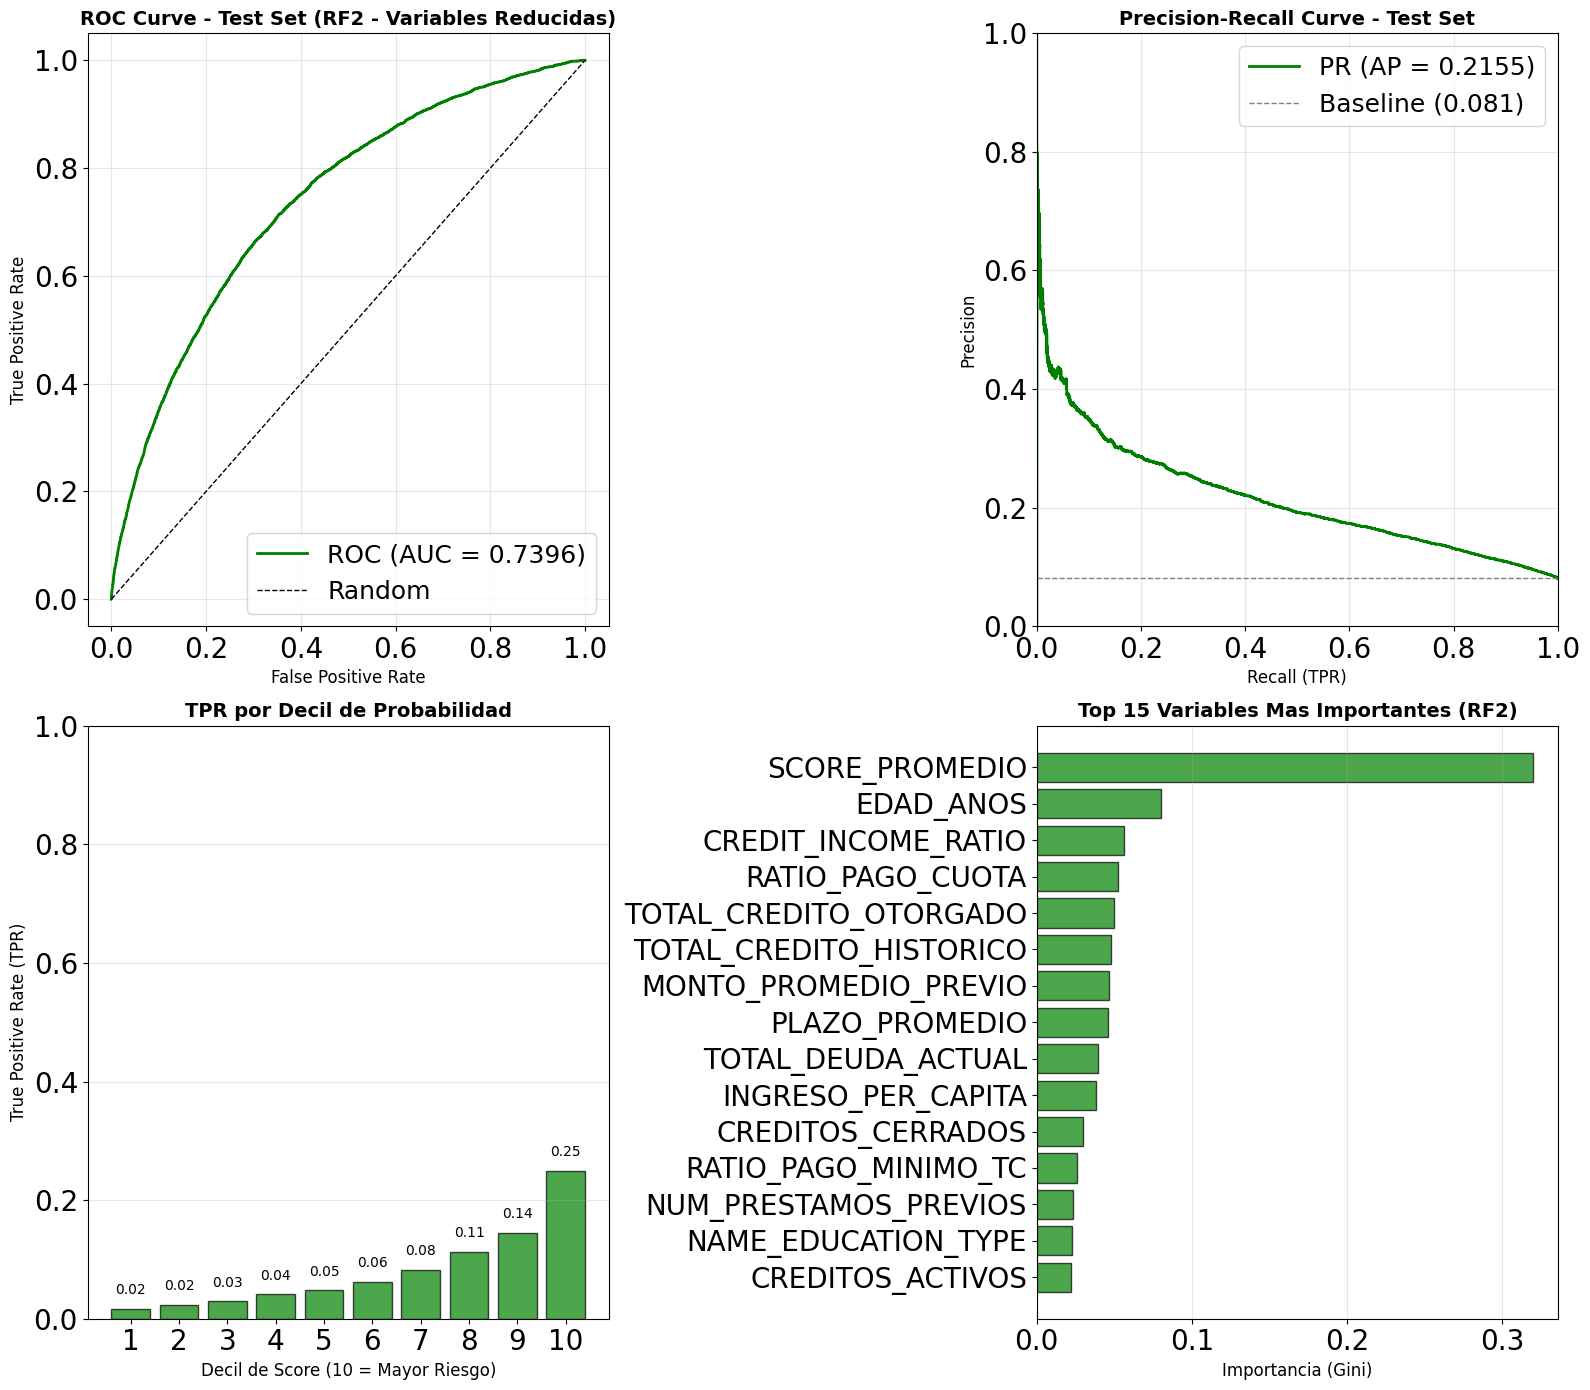


Tabla de TPR por Decil:
 decil  positivos  total   tpr
    10       1530   6151 0.249
     9        886   6150 0.144
     8        690   6150 0.112
     7        509   6150 0.083
     6        380   6150 0.062
     5        294   6151 0.048
     4        252   6150 0.041
     3        180   6150 0.029
     2        142   6150 0.023
     1        102   6151 0.017


In [29]:
# =============================================================================
# VISUALIZACIONES - MODELO 2
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results2 = pd.DataFrame({
    'y_true': y2_test,
    'y_proba': y2_test_proba
})
test_results2['decil'] = pd.qcut(test_results2['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats2 = test_results2.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats2.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats2 = decil_stats2.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ROC Curve
fpr2, tpr2, _ = roc_curve(y2_test, y2_test_proba)
axes[0, 0].plot(fpr2, tpr2, linewidth=2, color='green', label=f'ROC (AUC = {test2_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve - Test Set (RF2 - Variables Reducidas)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision2, recall2, _ = precision_recall_curve(y2_test, y2_test_proba)
sort_idx2 = np.argsort(recall2)
recall_sorted2 = recall2[sort_idx2]
precision_sorted2 = precision2[sort_idx2]

axes[0, 1].plot(recall_sorted2, precision_sorted2, linewidth=2, color='green', label=f'PR (AP = {test2_ap:.4f})')
axes[0, 1].axhline(y=y2_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y2_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall (TPR)', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TPR por Decil
axes[1, 0].bar(decil_stats2['decil'], decil_stats2['tpr'], color='green', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[1, 0].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

for i, row in decil_stats2.iterrows():
    axes[1, 0].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

# Feature Importance (Top 15)
top_features2 = feature_importance2.head(15)
axes[1, 1].barh(range(len(top_features2)), top_features2['Importancia'].values, color='green', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features2)))
axes[1, 1].set_yticklabels(top_features2['Variable'].values)
axes[1, 1].set_xlabel('Importancia (Gini)', fontsize=12)
axes[1, 1].set_title('Top 15 Variables Mas Importantes (RF2)', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/random_forest2_curves.png', dpi=300, bbox_inches='tight')
print(f"Graficas guardadas: {OUTPUT_DIR}/random_forest2_curves.png")

plt.show()

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats2.to_string(index=False))


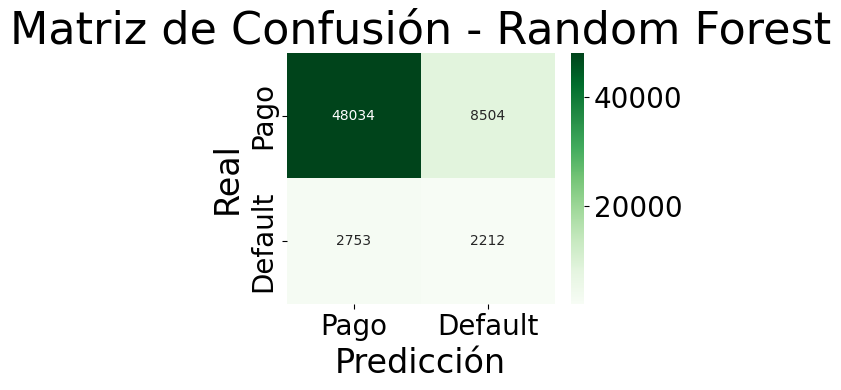

array([[48034,  8504],
       [ 2753,  2212]])

In [30]:
# Matriz de confusión del modelo Random Forest (modelo 2) en tonos verdes
cm_rf = confusion_matrix(y2_test, y2_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=['Pago', 'Default'],
    yticklabels=['Pago', 'Default']
)
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

cm_rf

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, average_precision_score
)
import xgboost as xgb
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURACIÓN
# =============================================================================
TEST_SIZE = 0.2
RANDOM_STATE = 42
CV_FOLDS = 5

# Hiperparámetros XGBoost - Modelo 1
N_ESTIMATORS = 100
MAX_DEPTH = 6
LEARNING_RATE = 0.1
MIN_CHILD_WEIGHT = 5
SUBSAMPLE = 0.8
COLSAMPLE_BYTREE = 0.8

# Directorio de salida
OUTPUT_DIR = "../../data/xgboost-output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("="*80)
print("MODELO XGBOOST - HOME CREDIT DEFAULT RISK")
print("="*80)
print(f"\nTipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)")
print(f"Algoritmo: Extreme Gradient Boosting (XGBoost)")
print(f"Directorio de salida: {OUTPUT_DIR}")


MODELO XGBOOST - HOME CREDIT DEFAULT RISK

Tipo de problema: CLASIFICACIÓN BINARIA (0 = Pago, 1 = Default)
Algoritmo: Extreme Gradient Boosting (XGBoost)
Directorio de salida: ../../data/xgboost-output


In [32]:
# =============================================================================
# 2. PREPARACIÓN DE DATOS
# =============================================================================
print("\n[2/15] Preparando datos...")

X = df.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = df['TARGET']

print(f"Variables predictoras: {X.shape[1]}")
print(f"Variable objetivo: {y.name}")

numeric_vars = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_vars = X.select_dtypes(include=['object']).columns.tolist()

print(f"Variables numericas: {len(numeric_vars)}")
print(f"Variables categoricas: {len(categorical_vars)}")



[2/15] Preparando datos...
Variables predictoras: 25
Variable objetivo: TARGET
Variables numericas: 22
Variables categoricas: 3


In [33]:
# =============================================================================
# 3. MANEJO DE VALORES FALTANTES
# =============================================================================
print("\n[3/15] Analizando valores faltantes...")

missing_pct = (X.isnull().sum() / len(X) * 100).sort_values(ascending=False)
missing_vars = missing_pct[missing_pct > 0]

if len(missing_vars) > 0:
    print(f"Variables con valores faltantes: {len(missing_vars)}")
    print(missing_vars.head(10))
    
    print("\nImputando valores faltantes...")
    for col in numeric_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].median(), inplace=True)
    
    for col in categorical_vars:
        if X[col].isnull().sum() > 0:
            X[col].fillna(X[col].mode()[0], inplace=True)
    
    print("Valores faltantes imputados")
else:
    print("No hay valores faltantes")



[3/15] Analizando valores faltantes...
Variables con valores faltantes: 5
TASA_INTERES_PROMEDIO   98.501
RATIO_PAGO_MINIMO_TC    80.726
PLAZO_PROMEDIO           5.486
RATIO_PAGO_CUOTA         5.164
SCORE_PROMEDIO           0.056
dtype: float64

Imputando valores faltantes...
Valores faltantes imputados


In [34]:
# =============================================================================
# 4. CODIFICACIÓN DE VARIABLES CATEGÓRICAS
# =============================================================================
print("\n[4/15] Codificando variables categoricas...")

label_encoders = {}

if len(categorical_vars) > 0:
    for col in categorical_vars:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
    
    print(f"{len(categorical_vars)} variables codificadas")
    print(f"Categorias: {categorical_vars}")



[4/15] Codificando variables categoricas...
3 variables codificadas
Categorias: ['NAME_FAMILY_STATUS', 'CODE_GENDER', 'NAME_EDUCATION_TYPE']


In [35]:
# =============================================================================
# 5. DIVISIÓN TRAIN/TEST
# =============================================================================
print("\n[5/15] Dividiendo datos en Train/Test...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print(f"Train set: {X_train.shape[0]:,} usuarios ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} usuarios ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nDistribucion TARGET en Train:")
print(f"  Clase 0 (Pago): {(y_train==0).sum():,} ({(y_train==0).sum()/len(y_train)*100:.2f}%)")
print(f"  Clase 1 (Default): {(y_train==1).sum():,} ({(y_train==1).sum()/len(y_train)*100:.2f}%)")



[5/15] Dividiendo datos en Train/Test...
Train set: 246,008 usuarios (80.0%)
Test set:  61,503 usuarios (20.0%)

Distribucion TARGET en Train:
  Clase 0 (Pago): 226,148 (91.93%)
  Clase 1 (Default): 19,860 (8.07%)


In [36]:
# =============================================================================
# 6. NOTA SOBRE NORMALIZACIÓN
# =============================================================================
print("\n[6/15] Nota sobre normalizacion...")

# XGBoost NO requiere normalización ya que es un modelo basado en árboles
# Los árboles de decisión son invariantes a transformaciones monótonas de las features
# Usamos los datos sin escalar para mejor interpretabilidad

print("XGBoost no requiere normalizacion de datos")
print("Los arboles de decision son invariantes a escalas de las variables")
print("Se usaran los datos originales (sin escalar)")



[6/15] Nota sobre normalizacion...
XGBoost no requiere normalizacion de datos
Los arboles de decision son invariantes a escalas de las variables
Se usaran los datos originales (sin escalar)


In [37]:
# =============================================================================
# 7. ENTRENAMIENTO DEL MODELO XGBOOST 1
# =============================================================================
print("\n[7/15] Entrenando XGBoost...")

# Calcular scale_pos_weight para manejar desbalance de clases
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale_pos_weight (ratio negativo/positivo): {scale_pos_weight:.2f}")

model = xgb.XGBClassifier(
    n_estimators=N_ESTIMATORS,
    max_depth=MAX_DEPTH,
    learning_rate=LEARNING_RATE,
    min_child_weight=MIN_CHILD_WEIGHT,
    subsample=SUBSAMPLE,
    colsample_bytree=COLSAMPLE_BYTREE,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    eval_metric='auc',
    use_label_encoder=False
)

model.fit(X_train, y_train)

print("\nModelo entrenado exitosamente")
print(f"Numero de arboles: {model.n_estimators}")
print(f"Profundidad maxima: {model.max_depth}")
print(f"Learning rate: {model.learning_rate}")
print(f"Min child weight: {model.min_child_weight}")
print(f"Subsample: {model.subsample}")
print(f"Colsample bytree: {model.colsample_bytree}")



[7/15] Entrenando XGBoost...
Scale_pos_weight (ratio negativo/positivo): 11.39



Modelo entrenado exitosamente
Numero de arboles: 100
Profundidad maxima: 6
Learning rate: 0.1
Min child weight: 5
Subsample: 0.8
Colsample bytree: 0.8


In [38]:
# =============================================================================
# 8. VALIDACIÓN CRUZADA
# =============================================================================
print(f"\n[8/15] Validacion Cruzada ({CV_FOLDS}-fold en Train)...")

cv_scores = cross_val_score(
    model, X_train, y_train, 
    cv=CV_FOLDS, 
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC por fold: {cv_scores}")
print(f"Media: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



[8/15] Validacion Cruzada (5-fold en Train)...


ROC-AUC por fold: [0.75090577 0.73973452 0.74770615 0.75076835 0.75653203]
Media: 0.7491 (+/- 0.0055)


In [39]:
# =============================================================================
# 9. PREDICCIONES
# =============================================================================
print("\n[9/15] Generando predicciones...")

y_train_pred = model.predict(X_train)
y_train_proba = model.predict_proba(X_train)[:, 1]

y_test_pred = model.predict(X_test)
y_test_proba = model.predict_proba(X_test)[:, 1]

print("Predicciones generadas")



[9/15] Generando predicciones...
Predicciones generadas


In [40]:
# =============================================================================
# 10. EVALUACIÓN EN TRAIN
# =============================================================================
print("\n[10/15] Evaluando modelo en TRAIN SET...")
print("="*80)

train_auc = roc_auc_score(y_train, y_train_proba)
train_ap = average_precision_score(y_train, y_train_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {train_auc:.4f}")
print(f"Average Precision: {train_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_train, y_train_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_train = confusion_matrix(y_train, y_train_pred)
print(cm_train)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_train[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_train[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_train[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_train[1,1]:,} - Predijo 'Default' y si hizo default")



[10/15] Evaluando modelo en TRAIN SET...

Metricas Globales:
ROC-AUC Score: 0.7955
Average Precision: 0.2867

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.97      0.71      0.82    226148
 Default (1)       0.18      0.73      0.29     19860

    accuracy                           0.71    246008
   macro avg       0.57      0.72      0.56    246008
weighted avg       0.90      0.71      0.78    246008


Confusion Matrix:
[[161358  64790]
 [  5441  14419]]

Interpretacion:
  Verdaderos Negativos (TN): 161,358 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 64,790 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 5,441 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 14,419 - Predijo 'Default' y si hizo default


In [41]:
# =============================================================================
# 11. EVALUACIÓN EN TEST
# =============================================================================
print("\n[11/15] Evaluando modelo en TEST SET (metricas definitivas)...")
print("="*80)

test_auc = roc_auc_score(y_test, y_test_proba)
test_ap = average_precision_score(y_test, y_test_proba)

print(f"\nMetricas Globales:")
print(f"ROC-AUC Score: {test_auc:.4f}")
print(f"Average Precision: {test_ap:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Pago (0)', 'Default (1)']))

print(f"\nConfusion Matrix:")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
print(f"\nInterpretacion:")
print(f"  Verdaderos Negativos (TN): {cm_test[0,0]:,} - Predijo 'Pago' y si pago")
print(f"  Falsos Positivos (FP): {cm_test[0,1]:,} - Predijo 'Default' pero pago")
print(f"  Falsos Negativos (FN): {cm_test[1,0]:,} - Predijo 'Pago' pero hizo default [CRITICO]")
print(f"  Verdaderos Positivos (TP): {cm_test[1,1]:,} - Predijo 'Default' y si hizo default")



[11/15] Evaluando modelo en TEST SET (metricas definitivas)...

Metricas Globales:
ROC-AUC Score: 0.7529
Average Precision: 0.2338

Classification Report:
              precision    recall  f1-score   support

    Pago (0)       0.96      0.71      0.82     56538
 Default (1)       0.17      0.67      0.27      4965

    accuracy                           0.71     61503
   macro avg       0.56      0.69      0.54     61503
weighted avg       0.90      0.71      0.77     61503


Confusion Matrix:
[[40165 16373]
 [ 1646  3319]]

Interpretacion:
  Verdaderos Negativos (TN): 40,165 - Predijo 'Pago' y si pago
  Falsos Positivos (FP): 16,373 - Predijo 'Default' pero pago
  Falsos Negativos (FN): 1,646 - Predijo 'Pago' pero hizo default [CRITICO]
  Verdaderos Positivos (TP): 3,319 - Predijo 'Default' y si hizo default


In [42]:
# =============================================================================
# 12. COMPARACIÓN TRAIN VS TEST
# =============================================================================
print("\n[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...")
print("="*80)

print(f"\n{'Metrica':<25} {'Train':<12} {'Test':<12} {'Diferencia':<12}")
print("-" * 65)
print(f"{'ROC-AUC':<25} {train_auc:<12.4f} {test_auc:<12.4f} {abs(train_auc-test_auc):<12.4f}")
print(f"{'Average Precision':<25} {train_ap:<12.4f} {test_ap:<12.4f} {abs(train_ap-test_ap):<12.4f}")

diff_auc = abs(train_auc - test_auc)
if diff_auc < 0.02:
    print("\nExcelente generalizacion (diferencia < 2%)")
elif diff_auc < 0.05:
    print("\nBuena generalizacion (diferencia < 5%)")
elif diff_auc < 0.10:
    print("\nPosible ligero overfitting (diferencia 5-10%)")
else:
    print("\nOverfitting detectado (diferencia > 10%)")



[12/15] Comparando TRAIN vs TEST (analisis de overfitting)...

Metrica                   Train        Test         Diferencia  
-----------------------------------------------------------------
ROC-AUC                   0.7955       0.7529       0.0426      
Average Precision         0.2867       0.2338       0.0529      

Buena generalizacion (diferencia < 5%)


In [43]:
# =============================================================================
# 13. IMPORTANCIA DE VARIABLES
# =============================================================================
print("\n[13/15] Calculando importancia de variables...")
print("="*80)

# XGBoost usa importancia basada en gain (ganancia promedio en splits)
# También puede usar weight (número de veces que se usa) o cover (muestras cubiertas)

feature_importance = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': model.feature_importances_
}).sort_values('Importancia', ascending=False)

print("\nTop 20 variables mas importantes para predecir default:\n")
print(feature_importance.head(20).to_string(index=False))

print("\nInterpretacion de importancia (Gain):")
print("  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) o 1 (Default)")
print("  - Gain mide la mejora promedio en la función objetivo al usar la variable")
print("  - Valores mas altos = mayor capacidad para mejorar las predicciones")
print("  - Basado en la ganancia promedio en todos los árboles del ensemble")



[13/15] Calculando importancia de variables...

Top 20 variables mas importantes para predecir default:

                Variable  Importancia
          SCORE_PROMEDIO        0.268
     NAME_EDUCATION_TYPE        0.074
             CODE_GENDER        0.063
        RATIO_PAGO_CUOTA        0.041
    RATIO_PAGO_MINIMO_TC        0.037
  TOTAL_CREDITO_OTORGADO        0.035
        CREDITOS_ACTIVOS        0.035
          PLAZO_PROMEDIO        0.034
               EDAD_ANOS        0.034
       CREDITOS_CERRADOS        0.032
      NAME_FAMILY_STATUS        0.030
      TOTAL_DEUDA_ACTUAL        0.027
 TOTAL_CREDITO_HISTORICO        0.026
     CREDIT_INCOME_RATIO        0.025
TOTAL_CREDITO_DISPONIBLE        0.025
             NUM_ACTIVOS        0.025
          PCT_MESES_MORA        0.025
   MONTO_PROMEDIO_PREVIO        0.023
   NUM_PRESTAMOS_PREVIOS        0.022
      INGRESO_PER_CAPITA        0.022

Interpretacion de importancia (Gain):
  - Problema de CLASIFICACIÓN BINARIA: predecir 0 (Pago) 


[14/15] Generando visualizaciones...
Graficas guardadas: ../../data/xgboost-output/xgboost1_curves.png


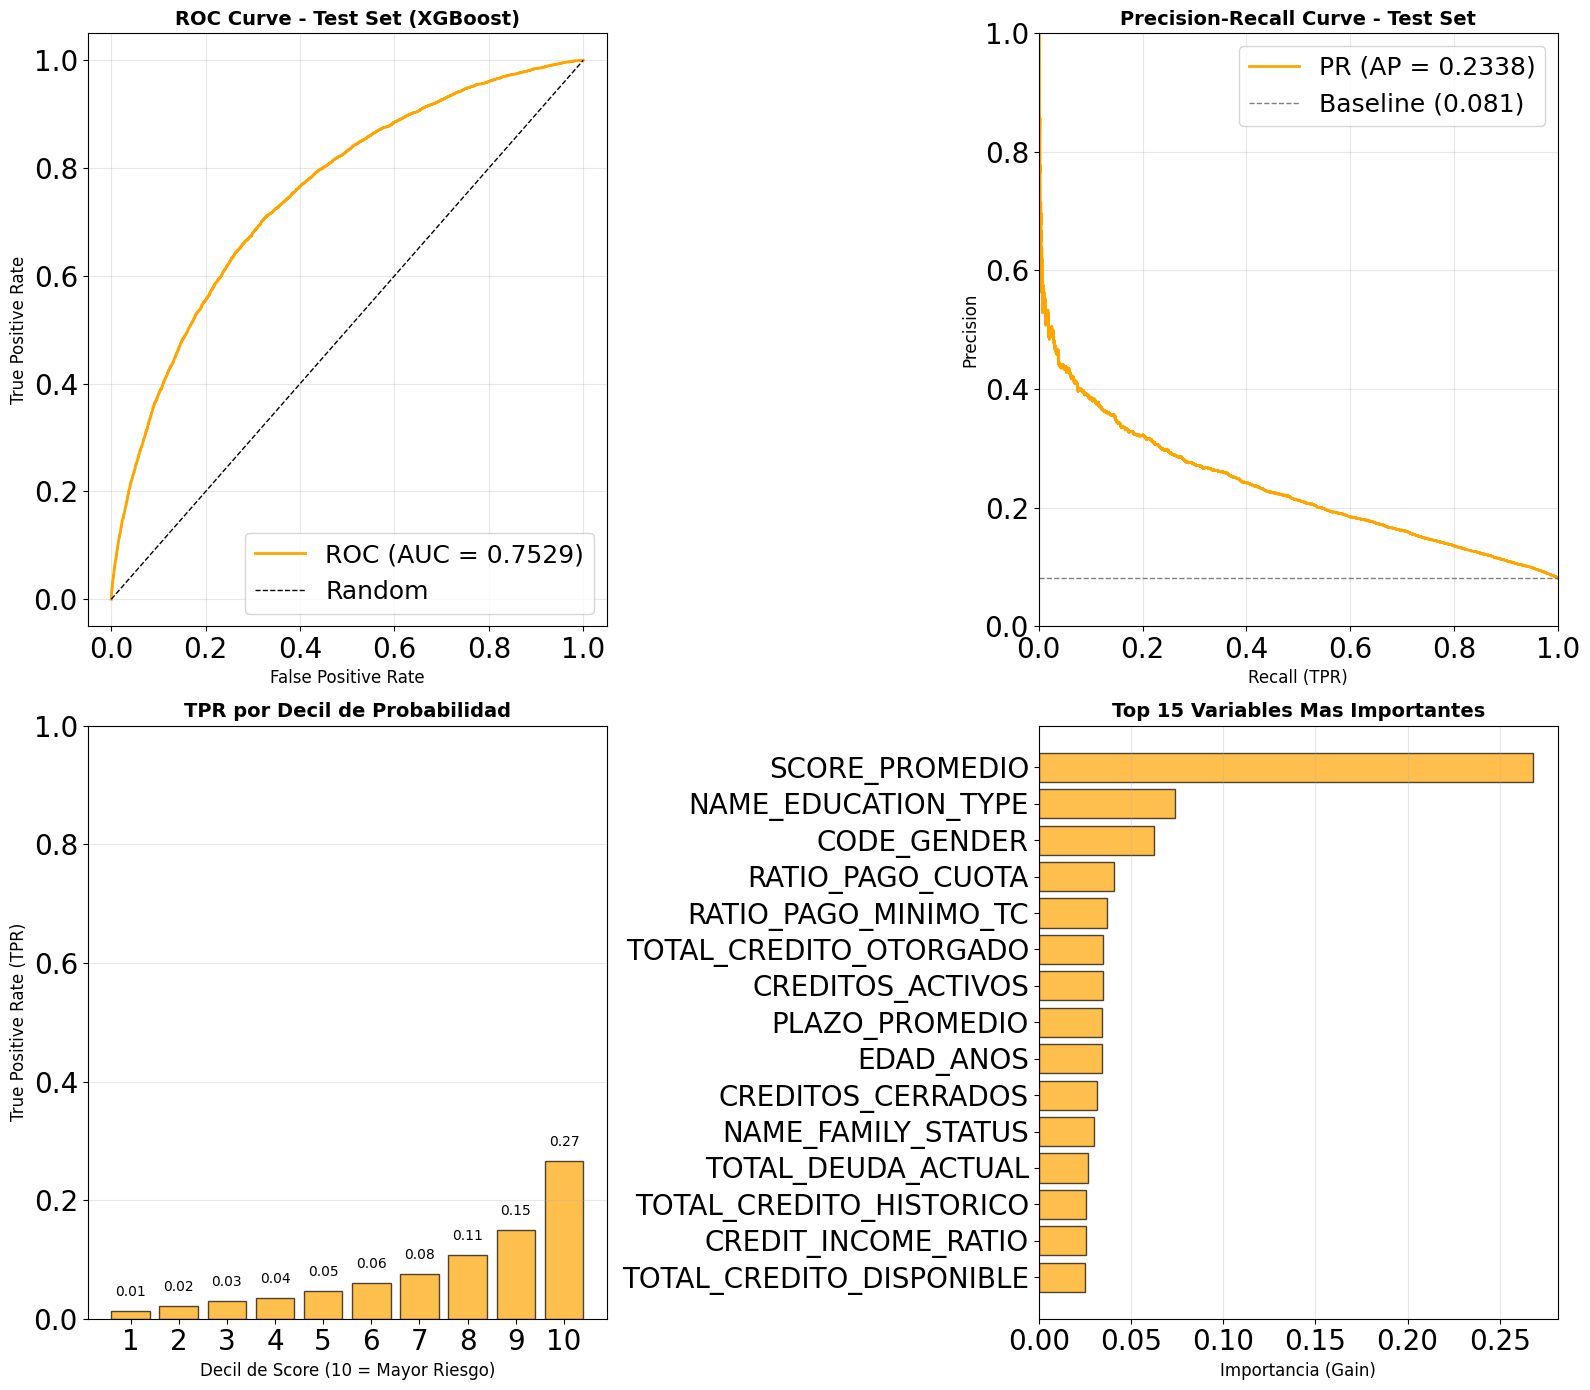


Tabla de TPR por Decil:
 decil  positivos  total   tpr
    10       1636   6151 0.266
     9        919   6150 0.149
     8        663   6150 0.108
     7        462   6150 0.075
     6        370   6150 0.060
     5        292   6151 0.047
     4        219   6150 0.036
     3        189   6150 0.031
     2        133   6150 0.022
     1         82   6151 0.013


In [44]:
# =============================================================================
# 14. VISUALIZACIONES
# =============================================================================
print("\n[14/15] Generando visualizaciones...")

# Calcular deciles
test_results = pd.DataFrame({
    'y_true': y_test,
    'y_proba': y_test_proba
})
test_results['decil'] = pd.qcut(test_results['y_proba'], q=10, labels=False, duplicates='drop') + 1

# Calcular TPR por decil
decil_stats = test_results.groupby('decil').agg({
    'y_true': ['sum', 'count', 'mean']
}).reset_index()
decil_stats.columns = ['decil', 'positivos', 'total', 'tpr']
decil_stats = decil_stats.sort_values('decil', ascending=False)

# Crear gráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
axes[0, 0].plot(fpr, tpr, linewidth=2, color='orange', label=f'ROC (AUC = {test_auc:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve - Test Set (XGBoost)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_proba)
sort_idx = np.argsort(recall)
recall_sorted = recall[sort_idx]
precision_sorted = precision[sort_idx]

axes[0, 1].plot(recall_sorted, precision_sorted, linewidth=2, color='orange', label=f'PR (AP = {test_ap:.4f})')
axes[0, 1].axhline(y=y_test.mean(), color='gray', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall (TPR)', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve - Test Set', fontsize=14, fontweight='bold')
axes[0, 1].set_xlim([0, 1])
axes[0, 1].set_ylim([0, 1])
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# TPR por Decil
axes[1, 0].bar(decil_stats['decil'], decil_stats['tpr'], color='orange', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Decil de Score (10 = Mayor Riesgo)', fontsize=12)
axes[1, 0].set_ylabel('True Positive Rate (TPR)', fontsize=12)
axes[1, 0].set_title('TPR por Decil de Probabilidad', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(range(1, 11))
axes[1, 0].grid(alpha=0.3, axis='y')
axes[1, 0].set_ylim(0, 1)

for i, row in decil_stats.iterrows():
    axes[1, 0].text(row['decil'], row['tpr'] + 0.02, f"{row['tpr']:.2f}", 
                ha='center', va='bottom', fontsize=10)

# Feature Importance (Top 15)
top_features = feature_importance.head(15)
axes[1, 1].barh(range(len(top_features)), top_features['Importancia'].values, color='orange', alpha=0.7, edgecolor='black')
axes[1, 1].set_yticks(range(len(top_features)))
axes[1, 1].set_yticklabels(top_features['Variable'].values)
axes[1, 1].set_xlabel('Importancia (Gain)', fontsize=12)
axes[1, 1].set_title('Top 15 Variables Mas Importantes', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(f'{OUTPUT_DIR}/xgboost1_curves.png', dpi=300, bbox_inches='tight')
print(f"Graficas guardadas: {OUTPUT_DIR}/xgboost1_curves.png")

plt.show()

# Imprimir tabla de deciles
print("\nTabla de TPR por Decil:")
print(decil_stats.to_string(index=False))


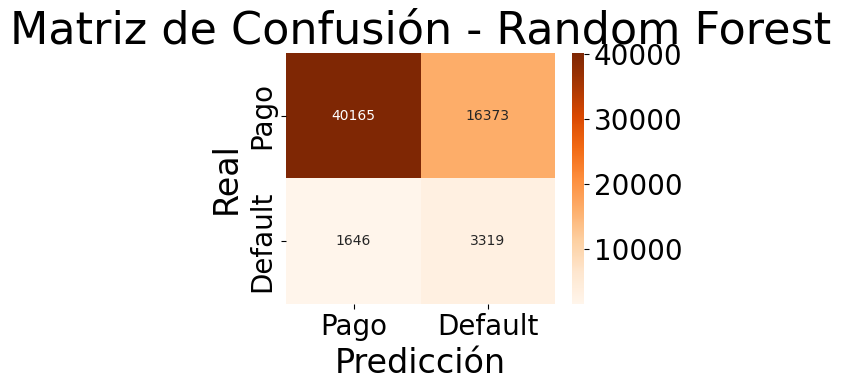

array([[40165, 16373],
       [ 1646,  3319]])

In [45]:
# Matriz de confusión del modelo Random Forest (modelo 2) en tonos verdes
cm_xg = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm_xg,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=['Pago', 'Default'],
    yticklabels=['Pago', 'Default']
)
plt.title("Matriz de Confusión - Random Forest")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()

cm_xg